# Couette flow example
This is an example of using the Couette flow
A two dimensional Couette flow is initialized and simulated. Afterwards the energy and the velocity field is plotted.

In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch

## Setup
* for running on GPU: device = "cuda". CUDA drivers are required!
* dtype=torch.float32 for single precision - float64 for double precision
* select collision model (here BGKCollision) - try also KBCCollision or RegularizedCollision

### Code:
* Reporters will grab the results in between simulation steps (see reporters.py and simulation.py)
* Output: Column 1: simulation steps, Column 2: time in LU, Column 3: kinetic energy in PU
* Output: separate VTK-file with ux,uy,(uz) and p for every 100. time step in ./output

In [2]:
nmax     = 200000
nconsole = 1000
nreport  = 100
epsilon  = 0.001 # convergence condition: .1 % relative change

context = lt.Context(device = torch.device("cuda"), dtype=torch
                   .float64, use_native=False)
flow = lt.CouetteFlow2D(resolution=16, reynolds_number=100, mach_number=0.1,
                        context=context)
collision = lt.BGKCollision(tau=flow.units.relaxation_parameter_lu)
simulation = lt.Simulation(flow=flow, collision=collision, reporter=[])

Energy = lt.IncompressibleKineticEnergy(flow)
energy_reporter_internal = lt.ObservableReporter(Energy, interval=nreport, out=None)
simulation.reporter.append(energy_reporter_internal)
simulation.reporter.append(lt.ObservableReporter(Energy, interval=nconsole)) # print energy
simulation.reporter.append(lt.VTKReporter(flow, interval=nreport, filename_base="./data/couette"))

steps     time     IncompressibleKineticEnergy
steps     time     IncompressibleKineticEnergy


## Run simulation

In [3]:
energy_new = 0
mlups = 0
iterations = int(nmax//nconsole)
for _ in range(iterations):
    energy_old = energy_new
    energy_new = Energy(flow.f).mean()
    mlups += simulation(nconsole)
    if abs((energy_new - energy_old)/energy_new) < epsilon:
        print("CONVERGENCE! Less than ", epsilon*100, " % relative change")
        break
print("avg MLUPS: ", mlups/iterations)

0 0.0 0.0
1000 3.6084391824351614 0.09987363345136614
2000 7.216878364870323 0.12556478520881784
3000 10.825317547305485 0.14315850637389968
4000 14.433756729740645 0.15471972716568078
5000 18.042195912175806 0.16195109617388337
6000 21.65063509461097 0.16633894553199507
7000 25.25907427704613 0.16895585682542924
8000 28.86751345948129 0.17050141813352296
9000 32.47595264191645 0.17140916681261695
10000 36.08439182435161 0.17194060853925477
11000 39.692831006786776 0.1722511666918006
12000 43.30127018922194 0.17243245290823989
13000 46.9097093716571 0.17253821163017471
14000 50.51814855409226 0.1725998867865115
CONVERGENCE! Less than  0.1  % relative change
avg MLUPS:  0.01575229146099233


## Post process
### Energy Reporter
* Grab output of kinetic energy reporter

(141, 3)


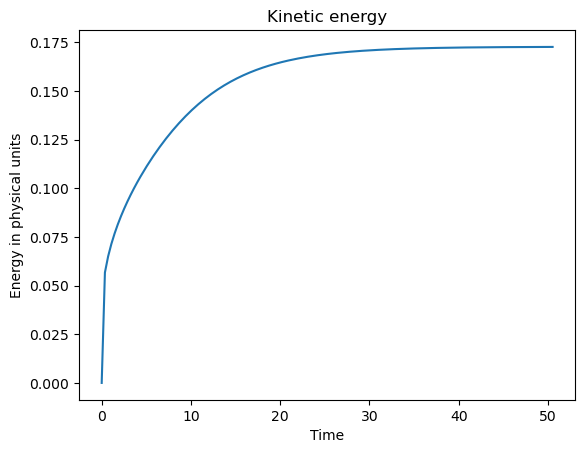

In [4]:
energy = np.array(simulation.reporter[0].out)
print(energy.shape)
plt.plot(energy[:,1],energy[:,2])
plt.title('Kinetic energy')
plt.xlabel('Time')
plt.ylabel('Energy in physical units')
plt.show()

### Velocity
We calculate the speed in Lettuce units depending on the last 'f'. Then we convert this velocity into physical units. For further investigations the tensor must be converted into a Numpy-Array. The norm of the fractions in x and y direction is plotted afterwards.

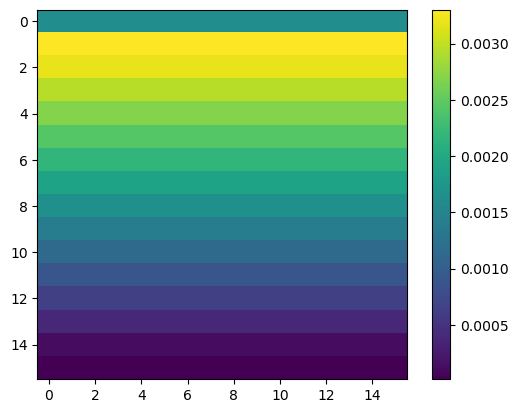

In [5]:
u_x = context.convert_to_ndarray(flow.u_pu)[0]
plt.imshow(u_x.transpose())
plt.colorbar()
plt.show()